<a href="https://colab.research.google.com/github/DeltSystem32/CIS3187-Assignment/blob/master/CIS3187_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Intelligence Coursework: Neural Network
## By Daniel Anthony Cilia 315499(M)
---



## Project Imports



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read and parse data

Obtain testing and traning data from two CSV files in the project repository on Github.

The data consists of 5-bit numbers being mapped to 3-bit via the Boolean function ¬ABC.

Converters are used to map values to string upon import in order to retain all leading zeros.

#### Training set:

In [296]:
training_data_url = "https://raw.githubusercontent.com/DeltSystem32/CIS3187-Assignment/master/training_data.csv?token=AIW66N5TCWXKRMEIPQPTPES6ENAXA"
training_df = pd.read_csv(training_data_url, converters={'input': lambda x: str(x), 'output': lambda x: str(x)})
training_df

,Num,input,output
0,1,00000,100
1,3,00010,100
2,4,00011,100
3,5,00100,101
4,7,00110,101
5,8,00111,101
6,9,01000,110
7,10,01001,110
8,11,01010,110
9,12,01011,110


#### Testing set:

In [297]:
testing_data_url = "https://raw.githubusercontent.com/DeltSystem32/CIS3187-Assignment/master/testing_data.csv?token=AIW66N6FBMAJSI6JR2GHI626ENAXE"
testing_df = pd.read_csv(testing_data_url, converters={'input': lambda x: str(x), 'output': lambda x: str(x)})
testing_df

,Num,input,output
0,2,00001,100
1,6,00101,101
2,13,01100,111
3,16,01111,111
4,23,10110,001
5,28,11011,010


#### Size of data:

In [298]:
print("Size of training set: " + str(len(training_df)))
print("Size of testing set: "+ str(len(testing_df)))

Size of training set: 26
Size of testing set: 6


## MLP Parameters

The Neural Network to be implemented will consist of the following:
*   **Number of input neurons**: 5
*   **Number of output neurons**: 3
*   **Number of hidden layers**: 1
*   **Number of hidden neurons**: 4
*   **Error threshold**: 0.2
*   **Learning rate**: 0.2
*   **Maximum number of epochs**: 999
*   **Transformation function**: Sigmoid

In [0]:
class parameters:
  NUM_IN_NEURONS = 5
  NUM_OUT_NEURONS = 3
  NUM_HIDDEN_LAYERS = 1
  NUM_HIDDEN_NEURONS = 4
  ERROR_THRESHOLD = 0.2
  LEARNING_RATE = 0.2
  MAX_EPOCHS = 999

### Sigmoid function implementation

The method will be called *transform()* so as to remain generic so that its body can be 'hotswapped' with other transformation functions if the need arises.

In [0]:
 import math

 def transform(x):
    #sigmoid
    return 1 / (1 + np.exp(-x))
    

#add to MLP parameters
parameters.transform = transform

## MLP Class

### Initialisation

We will first begin by declaring the MLP's initialisation function. An array of 5-bit binary numbers is to be received:

In [0]:
class MLP:
  layers = None
  outputs = None
  wH = None #hidden layer weights
  wO = None #output layer weights
    
  def __init__(self, input_df):
    epoch = 1
    is_converged = True
    epochs_list = []
    wH = self.generate_weights(parameters.NUM_IN_NEURONS,parameters.NUM_HIDDEN_NEURONS)
    wO = self.generate_weights(parameters.NUM_HIDDEN_NEURONS,parameters.NUM_OUT_NEURONS)

    print("------------------------------------------")
    while epoch <= parameters.MAX_EPOCHS:
      print("Epoch ", epoch)
      num_bad_facts = 0
      for index, fact in input_df.iterrows():
        input = np.array(list(fact["input"]),dtype=np.float64)
        target_output = np.array(list(fact["output"]),dtype=np.float64)
        # print("Input: ", input)
        # print("Expected Output: ", target_output)

        result = self.feedforward(wH, wO, input)
        output, hidden_output = result[0], result[1]

        error = self.calculate_error(target_output, output)
        is_good_fact = self.check_fact(error)
        if not is_good_fact:
          num_bad_facts += 1
          print("False")
          is_converged = False
          result = self.error_backpropagation(wH, wO, input, hidden_output, output, target_output)
          wO = result[0]
          wH = result[1]
          # print(wO)
          # print(wH)
        else:
          print("True")
      if is_converged:
        break
      else:
        epochs_list.append([epoch, ((num_bad_facts / len(input_df)) * 100)])
        epoch += 1
        print("------------------------------------------")
    self.plot_epoch_graph(epochs_list)
        

To initialise the weights, we will need to do so randomly from -1 to 1. For this, a function is required to create a matrix of weights of any given size:

In [0]:
def generate_weights(self, columns, rows):
  return np.random.uniform(low=-1,high=1, size=(columns,rows))

#add to MLP
MLP.generate_weights = generate_weights

### Feed-forward

Function for applying the transformation function to all cells of a given array:

In [0]:
def transform_array(self, net):
  return [parameters.transform(j) for j in net]

# add to MLP
MLP.transform_array = transform_array

Loop through hidden layer and output layer, transforming input into MLP output. Matrix multiplication is performed using numpy's dot function:

In [0]:

def feedforward(self, wH, wO, inputs):
  netH = np.dot(inputs,wH)
  outH = self.transform_array(netH)

  netO = np.dot(outH,wO)
  outO = self.transform_array(netO)

  return outO, outH

MLP.feedforward = feedforward

### Fact Checking

For each output of the MLP, compare with the expected output and produce the error difference: 

In [0]:
def calculate_error(self, target_output, output):
  if(len(target_output) == len(output)):
    error = np.empty(len(output), dtype=np.float64)
    for i in range(len(output)):
      np.append(error, (target_output[i] - output[i]))
    return error

MLP.calculate_error = calculate_error

Given an array of errors, compare to error threshold and determine whether fact is good or bad:

In [0]:
def check_fact(self, error):
  error_threshold = parameters.ERROR_THRESHOLD

  for i in range(len(error)):
    if abs(error[i])> error_threshold: 
      return False #bad fact

  return True #good fact

MLP.check_fact = check_fact

### Error Backpropagation

Revise the weights of the MLP, beginning from the output layer. 

In [0]:
def error_backpropagation(self, wH, wO, input, hidden_output, output, target_output):
  learning_rate = parameters.LEARNING_RATE

  #output layer
  result = self.propagate_output_weights(learning_rate, wO, output, target_output)
  output_layer_weights = result[0]
  delta_out = result[1]

  #hidden layer
  result = self.propagate_hidden_weights(learning_rate, wH, hidden_output, delta_out)
  hidden_layer_weights = result[0]
  delta_out = result [1] #to be used should more layers be added in the future

  return output_layer_weights, hidden_layer_weights

MLP.error_backpropagation = error_backpropagation

Calculate the delta of each weight and total the weight difference. Return the new output weights and the delta values generated in the process.

In [0]:
def propagate_output_weights(self, learning_rate, wO, output, target_output):
  delta_matrix = np.empty(shape=np.shape(output))
  # for row in wO:
  #   delta_array = np.empty(len(row))
  #   for j in range(len(row)):
  #     delta_value =  output[j] * (1 - output[j]) * (target_output[j] - output[j])
  #     np.append(delta_array, delta_value)      
  #     row[j] += self.get_change_in_weight(learning_rate, delta_value, output[j])

  #   np.vstack((delta_matrix,delta_array))
  for(i,j), cell in np.ndenumerate(wO):
    delta_matrix = np.empty(shape=np.shape(wO))
    delta_array = np.empty(len(wO[i]))
    delta_value =  output[j] * (1 - output[j]) * (target_output[j] - output[j])
    np.append(delta_array, delta_value)

    cell += self.get_change_in_weight(learning_rate, delta_value, output[j])
    np.vstack((delta_matrix,delta_array))

  return wO, delta_matrix

MLP.propagate_output_weights = propagate_output_weights

Do the same for the weights of the hidden layer. This follows a more complicated process.

In [0]:
def propagate_hidden_weights(self, learning_rate, wH, outH, delta_output):
  delta_matrix = np.empty(shape=np.shape(wH))
  # for row in wH:
  #   delta_array = np.empty(len(row))
  #   for j, cell in range(len(row)):
  #     print(len(row))
  #     delta_value = outH[j] * (1 - outH[j]) * self.summation_hidden(delta_output, cell)
  #     np.append(delta_array, delta_value)
  #     cell += self.get_change_in_weight(learning_rate, delta_value, outH[j])
    
  #   np.vstack((delta_matrix,delta_array))
  for (i, j), cell in np.ndenumerate(wH):
    delta_matrix = np.empty(shape=np.shape(wH))
    delta_array = np.empty(len(wH[i]))
    delta_value = outH[j] * (1 - outH[j]) * self.summation_hidden(delta_output, cell)
    np.append(delta_array, delta_value)

    cell += self.get_change_in_weight(learning_rate, delta_value, outH[j])
                                     
    np.vstack((delta_matrix, delta_array))
  return wH, delta_matrix
      
MLP.propagate_hidden_weights = propagate_hidden_weights

In [0]:
def summation_hidden(self, delta_output, weight):
  sum = 0
  for delta in delta_output:
    sum += delta * weight
  # print(sum)
  return sum

MLP.summation_hidden = summation_hidden

In [0]:
def get_change_in_weight(self, learning_rate, delta_value, output_value):
  return learning_rate * delta_value * output_value

MLP.get_change_in_weight = get_change_in_weight

## Graph Plotting

In [0]:
def plot_epoch_graph(self, epoch_list):
  epochs = np.array(epoch_list)

  for e in epoch_list:
    np.append(epochs, e)
  
  plt.plot(epochs[:,0], epochs[:,1])
  plt.xlabel('Epochs')
  plt.ylabel('% of Bad Facts')

  plt.title("Training Set")
  plt.show()

MLP.plot_epoch_graph = plot_epoch_graph

## Test Runner

------------------------------------------
Epoch  1
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  2
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  3
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  4
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
------------------------------------------
Epoch  5
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


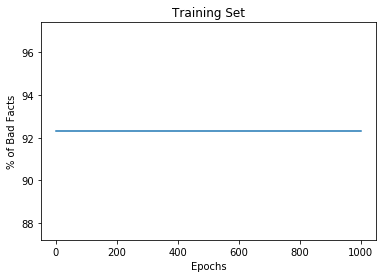

In [313]:
mlp = MLP(training_df)